In [1]:
from tifffile import imread, imwrite
from pathlib import Path
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
# import pyclesperanto_prototype as cle

In [2]:
# root_path = Path("../../pvc/scratch/interaction_cells/datasets/")
root_path = Path(r"C:\Users\Cyril\Desktop\Code\tumorscope\DATA")
print("Loading image...")
image = imread(root_path / "series003_cCAR_tumor.tif")

image_actin_channel = image[:, 1, ...]
image_calcium_channel = image[:, 2, ...]
image = image[:, 0, ...]
image.shape

Loading image...


(162, 1412, 1412)

In [3]:
image_resized =  resize(image, (image.shape[0], image.shape[1] // 2, image.shape[2] // 2), anti_aliasing=True)
image_actin_resized = resize(image_actin_channel, (image_actin_channel.shape[0], image_actin_channel.shape[1] // 2, image_actin_channel.shape[2] // 2), anti_aliasing=True)
image_calcium_resized = resize(image_calcium_channel, (image_calcium_channel.shape[0], image_calcium_channel.shape[1] // 2, image_calcium_channel.shape[2] // 2), anti_aliasing=True)

In [4]:
import napari
v = napari.Viewer()

In [ ]:
v.add_image(image_resized, name="image", colormap="viridis")
v.add_image(image_actin_resized, name="actin", colormap="magma")
v.add_image(image_calcium_resized, name="calcium", colormap="red")

<Image layer 'calcium' at 0x1095bbb9960>

INFO:napari_ctc_io.reader:Loaded tracks from C:\Users\Cyril\Desktop\Code\tumorscope\DATA\tracked\man_track.txt
INFO:napari_ctc_io.reader:Running CTC format checks
INFO:napari_ctc_io.reader:Checks completed


In [6]:
from pyclesperanto_prototype import difference_of_gaussian
from skimage.segmentation import watershed
from skimage.measure import regionprops

In [7]:
actin_dog = difference_of_gaussian(image_actin_resized, 
                                   sigma1_x=5, sigma2_x=10,
                                   sigma1_y=5, sigma2_y=10,
                                   sigma1_z=0, sigma2_z=0
                                   ) * 1000
actin_dog = np.array(actin_dog, dtype=np.float32)

8 warnings generated.
8 warnings generated.
8 warnings generated.
8 warnings generated.


In [8]:
actin_dog_filtered = np.where(actin_dog < 0.1, 0, actin_dog)
# actin_dog_filtered = np.where(actin_dog_filtered > 0.3, 0, actin_dog_filtered)


In [9]:
actin_dog_filtered = np.array(actin_dog_filtered)

In [10]:
# actin_dog_filtered_labels = voronoi_otsu_labeling(actin_dog_filtered, spot_sigma=5, outline_sigma=2)
actin_dog_filtered_labels = np.zeros_like(actin_dog_filtered)
for t, frame in tqdm(enumerate(actin_dog_filtered), total=actin_dog_filtered.shape[0]):
    frame_flipped = np.max(frame) - frame
    frame_flipped = np.where(frame == 0, np.inf, frame_flipped)
    wshed = watershed(frame_flipped)
    actin_dog_filtered_labels[t] = np.where(frame != 0, wshed, 0)

  0%|          | 0/162 [00:00<?, ?it/s]

In [11]:
# calcium_mask = np.where(image_calcium_resized > 0.003, 1, 0)
# calcium_mask = np.array(calcium_mask, dtype=np.uint8)

In [12]:
def filter_labels_by_area(masks, min_area=None, max_area=None):
    """
    Filter labels by area using regionprops.
    """
    filtered_labels = np.zeros_like(masks, dtype=np.uint16)
    for t in tqdm(range(masks.shape[0])):
        labels = masks[t]
        props = regionprops(labels)
        for prop in props:
            area = prop.area
            if (min_area is None or area >= min_area) and (max_area is None or area <= max_area):
                filtered_labels[t][labels == prop.label] = prop.label
    return filtered_labels

In [13]:
actin_dog_filtered_labels = filter_labels_by_area(actin_dog_filtered_labels.astype(np.uint16), min_area=100, max_area=None)

  0%|          | 0/162 [00:00<?, ?it/s]

In [17]:
# Load a pretrained model
from trackastra.model import Trackastra
model = Trackastra.from_pretrained("general_2d", device="cuda")

INFO:trackastra.model.model:Loading model state from /home/achard/.trackastra/.models/general_2d/model.pt


/home/achard/.trackastra/.models/general_2d already downloaded, skipping.


INFO:trackastra.model.model_api:Using device cuda


In [30]:
# Track the cells
track_graph = model.track(image_resized, actin_dog_filtered_labels.astype(np.uint16), mode="greedy_nodiv", use_distance=True, max_distance=20, allow_divisions=False)  # or mode="ilp", or "greedy_nodiv"

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 162 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction
Extracting features: 100%|██████████| 162/162 [00:19<00:00,  8.46it/s]
INFO:trackastra.model.model_api:Building windows
Building windows: 100%|██████████| 159/159 [00:00<00:00, 11919.04it/s]
INFO:trackastra.model.model_api:Predicting windows
Computing associations: 100%|██████████| 159/159 [00:10<00:00, 15.68it/s]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1
INFO:trackastra.tracking.tracking:Added 55415 vertices, 75651 edges                          
INFO:trackastra.tracking.tracking:Running greedy tracker
Greedily matched edges:  62%|██████▏   | 46742/75651 [00:00<00:00, 147159.39it/s]


In [31]:
from trackastra.tracking import graph_to_ctc, graph_to_napari_tracks

In [ ]:
# Write to cell tracking challenge format
ctc_tracks, masks_tracked = graph_to_ctc(
      track_graph,
      actin_dog_filtered_labels,
      outdir="../../pvc/scratch/SHARE/cancer_cell_masks/series003_cCAR_tumor_tracked/actin_tracked",
)

Saving masks: 100%|██████████| 162/162 [00:00<00:00, 195.52it/s]


In [12]:
from napari_ctc_io.reader import read_ctc, _ctc_to_napari_tracks
from pathlib import Path
import pandas as pd
import numpy as np
import napari

In [13]:
masks, tracks, tracks_graph = read_ctc(
    Path(r"C:\Users\Cyril\Desktop\Code\tumorscope\DATA\tracked")
)

INFO:napari_ctc_io.reader:Loaded tracks from C:\Users\Cyril\Desktop\Code\tumorscope\DATA\tracked\man_track.txt
INFO:napari_ctc_io.reader:Running CTC format checks
INFO:napari_ctc_io.reader:Checks completed


In [14]:
tracks_df = pd.DataFrame(tracks, columns=["label", "frame", "x", "y"])
tracks_df.label = tracks_df.label.astype(np.uint16)
tracks_df.frame = tracks_df.frame.astype(np.uint16)

In [15]:
def filter_masks_by_time(masks, tracks_df, min_length=5):
    """
    Filter masks by their length.
    """
    masks_ids = tracks_df.groupby("label").size()
    valid_masks = masks_ids[masks_ids >= min_length].index.values
    # In the masks array (T, H, W), remove labels with values that are not in valid_masks
    masks_filtered = np.zeros_like(masks, dtype=np.uint16)
    for t in range(masks.shape[0]):
        masks_filtered[t] = np.where(np.isin(masks[t], valid_masks), masks[t], 0)
    tracks_df_filtered = tracks_df[tracks_df["label"].isin(valid_masks)]
    return masks_filtered, tracks_df_filtered

In [16]:
masks_filtered, filtered_tracks_df = filter_masks_by_time(masks, tracks_df, min_length=10)

In [17]:
v.add_labels(masks_filtered, name="masks_filtered")

filtered_tracks = filtered_tracks_df.to_numpy().astype(np.float32)
v.add_tracks(filtered_tracks, name="filtered_tracks")


<Tracks layer 'filtered_tracks' at 0x1d2e3a98070>

In [18]:
# import threshold
from skimage.measure import label, regionprops

In [ ]:
from skimage.measure import regionprops

def get_mask_area_over_time(masks_filtered):
    """
    Plot the area of each mask over time.
    """
    props_df = pd.DataFrame(columns=["label", "frame", "area"])
    
    # Collect area data for each label over time
    for t in range(masks_filtered.shape[0]):
        labels = masks_filtered[t]
        props = regionprops(labels)
        for prop in props:
            props_df = pd.concat([props_df, pd.DataFrame([[prop.label, t, prop.area]], 
                                                         columns=["label", "frame", "area"])])
    return props_df

In [71]:
control_masks = imread(root_path / "masks/series009_B_NT_tumor.tif")

In [66]:
props_df = get_mask_area_over_time(masks_filtered)

C:\Users\Cyril\AppData\Local\Temp\ipykernel_22312\4127661609.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  props_df = pd.concat([props_df, pd.DataFrame([[prop.label, t, prop.area]],


In [72]:
control_props_df = get_mask_area_over_time(control_masks.astype(np.uint16))

C:\Users\Cyril\AppData\Local\Temp\ipykernel_22312\4127661609.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  props_df = pd.concat([props_df, pd.DataFrame([[prop.label, t, prop.area]],


In [73]:
# plot_area_evolution(props_df[props_df.area < 5000])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_mean_area_evolution(dataframes, labels):
    """
    Plot the mean area evolution over time with error bars for multiple DataFrames.
    
    Parameters:
    - dataframes: List of pandas DataFrames, each containing "frame" and "area" columns.
    - labels: List of labels corresponding to each DataFrame for the legend.
    """
    with plt.style.context("dark_background"):
        fig = plt.figure(figsize=(10, 5))
        fig.patch.set_alpha(0)  # Make background transparent
        ax = fig.add_subplot(111)
        ax.set_facecolor((0, 0, 0, 0))

        # Define a color palette
        colors = sns.color_palette("husl", len(dataframes))

        # Plot each DataFrame
        for df, label, color in zip(dataframes, labels, colors):
            sns.lineplot(
                data=df,
                x="frame",
                y="area",
                ax=ax,
                color=color,
                linewidth=2,
                errorbar=("ci",95),  # Confidence interval for error bars
                label=label
            )

        ax.set_xlabel("Time")
        ax.set_ylabel("Mean Area")
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
        # ax.legend(loc="upper right", title="DataFrames")
        # Disable legend
        ax.legend().set_visible(False)
        # Save as SVG
        plt.savefig("mean_mask_area_over_time.svg", transparent=True, bbox_inches="tight")
        plt.show()

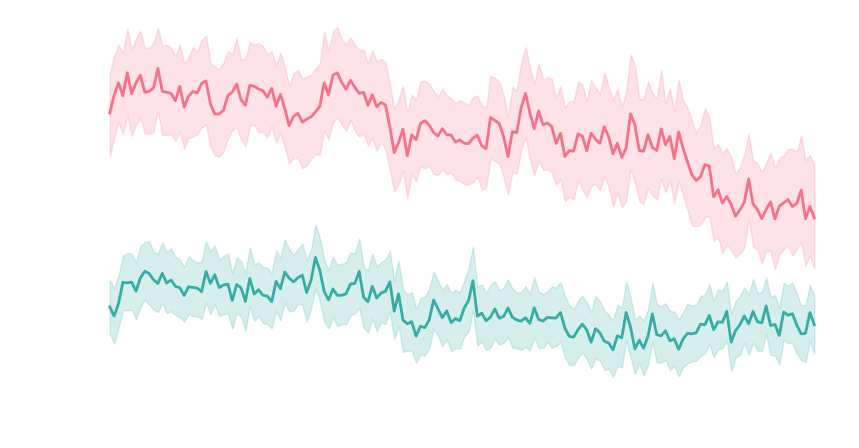

In [75]:
plot_mean_area_evolution([props_df[props_df.area < 5000], control_props_df[control_props_df.area < 5000]], labels=["CAR-T Cells", "Control"])

In [31]:
calcium_mask = np.where(image_calcium_resized > 0.003, 1, 0)
calcium_mask = label(calcium_mask, connectivity=1)

In [35]:
def filter_labels_by_area(masks, min_area=None, max_area=None):
    """
    Filter labels by area using regionprops.
    """
    filtered_labels = np.zeros_like(masks, dtype=np.uint16)
    for t in tqdm(range(masks.shape[0])):
        labels = masks[t]
        props = regionprops(labels)
        for prop in props:
            area = prop.area
            if (min_area is None or area >= min_area) and (max_area is None or area <= max_area):
                filtered_labels[t][labels == prop.label] = prop.label
    return filtered_labels

In [36]:
calcium_mask = filter_labels_by_area(calcium_mask.astype(np.uint16), min_area=100, max_area=None)

100%|██████████| 162/162 [00:01<00:00, 154.35it/s]


In [38]:
v.add_labels(calcium_mask, name="calcium_mask")

<Labels layer 'calcium_mask [1]' at 0x1c9ac133a90>

In [82]:
from dataclasses import dataclass
import numpy as np
from tqdm import tqdm

@dataclass
class TCell:
    label: int
    calcium_labels: dict
    N_frames_calcium_positive: int = 0

def get_calcium_positive_labels(actin_masks, calcium_masks):
    """
    Get the labels of the masks that have positive calcium channel, tracking them across frames.
    """
    merged_tracking_masks = actin_masks.copy()
    tcells = {}

    for t in tqdm(range(actin_masks.shape[0])):
        if np.all(calcium_masks[t] == 0):
            continue

        actin_labels = np.unique(actin_masks[t])
        calcium_labels = np.unique(calcium_masks[t])

        actin_labels = actin_labels[actin_labels != 0]
        calcium_labels = calcium_labels[calcium_labels != 0]

        for calcium_lab in calcium_labels:
            calcium_overlap = np.where(calcium_masks[t] == calcium_lab, actin_masks[t], 0)
            positive_actin_labels = np.unique(calcium_overlap)
            positive_actin_labels = positive_actin_labels[positive_actin_labels != 0]
            # in the WHOLE merged tracking masks, change the values of other labels that touch this calcium label to the first actin label
            if len(positive_actin_labels) > 0:
                # merged_tracking_masks[np.where(np.isin(merged_tracking_masks, positive_actin_labels))] = positive_actin_labels[0]
                # if the label is not in the dictionary, create a new TCell object
                if positive_actin_labels[0] not in tcells:
                    tcells[positive_actin_labels[0]] = TCell(label=positive_actin_labels[0], calcium_labels={t : calcium_lab})
                # if the label is in the dictionary, add the calcium label to the dictionary
                else:
                    tcells[positive_actin_labels[0]].calcium_labels[t] = calcium_lab
                tcells[positive_actin_labels[0]].N_frames_calcium_positive += 1
    return merged_tracking_masks, tcells

In [ ]:
_, tcells = get_calcium_positive_labels(masks_filtered, calcium_mask)

  0%|          | 0/162 [00:00<?, ?it/s]

100%|██████████| 162/162 [00:06<00:00, 23.82it/s]


In [91]:
def group_tcells_by_calcium_labels(tcells):
    """Find all T cells which at some point touch the same calcium label."""
    tcells_labels = {}
    for tcell in tcells.values():
        for calcium_label in tcell.calcium_labels.values():
            if tcell.label not in tcells_labels:
                tcells_labels[tcell.label] = [calcium_label]
            else:
                if calcium_label not in tcells_labels[tcell.label]:
                    tcells_labels[tcell.label].append(calcium_label)
    return tcells_labels

In [92]:
tcell_labels = group_tcells_by_calcium_labels(tcells)

In [93]:
tcell_labels

{78: [8],
 123: [25, 450, 891],
 7: [35, 473, 908],
 30: [49, 497, 905, 1381],
 22: [93],
 66: [105, 536],
 110: [111, 549, 965],
 2: [118],
 20: [120],
 5: [129, 567, 989],
 49: [147],
 73: [155, 593, 1000],
 105: [156, 600],
 85: [158, 603, 1001],
 16: [170],
 62: [181, 609, 1024],
 23: [175, 614, 1025, 1533, 1998],
 138: [178, 617, 1030, 1554],
 39: [189, 660],
 114: [192],
 47: [217, 666, 1070],
 36: [252, 687, 1143, 1642, 2102, 2572, 3056, 3543],
 14: [299],
 40: [322, 745],
 42: [323],
 18: [333],
 98: [347],
 58: [353, 762, 1241, 1722, 2171],
 126: [374, 808],
 103: [402, 819, 1287],
 3: [416, 825],
 8: [432],
 68: [433, 850],
 183: [464],
 104: [489],
 286: [492],
 375: [518, 940],
 236: [519, 935, 1409],
 371: [537],
 275: [550, 961],
 255: [551],
 50: [554],
 385: [575, 976, 1458],
 140: [615],
 157: [619],
 316: [633],
 278: [637, 1054, 1563],
 158: [647],
 171: [649, 1581],
 328: [656],
 205: [668, 1057, 1576, 2022, 2506],
 173: [681, 1083],
 343: [696],
 284: [704],
 164: 

In [96]:
def generate_tcells_table(tcells_labels):
    df = pd.DataFrame(columns=["tcell_label", "calcium_labels", "npositive_frames"])
    for tcell_label, calcium_labels in tcells_labels.items():
        npositive_frames = len(calcium_labels)
        if len(df) == 0:
            df = pd.DataFrame([[tcell_label, calcium_labels, npositive_frames]], columns=["tcell_label", "calcium_labels", "npositive_frames"])
        else:
            df = pd.concat([df, pd.DataFrame([[tcell_label, calcium_labels, npositive_frames]], columns=["tcell_label", "calcium_labels", "npositive_frames"])])
    return df

In [97]:
tcells_df = generate_tcells_table(tcell_labels)

In [98]:
tcells_df

,tcell_label,calcium_labels,npositive_frames
0,78,[8],1
0,123,"[25, 450, 891]",3
0,7,"[35, 473, 908]",3
0,30,"[49, 497, 905, 1381]",4
0,22,[93],1
...,...,...,...
0,5338,[7527],1
0,4597,[7547],1
0,4687,[7566],1
0,5040,[7587],1
